In [1]:
import sys 
if '..' not in sys.path:
    sys.path.append('../')
from utils import *
data_dict = load_data(verbose=True)

CONTENTS OF HDF5 FILE:
pose
	 ekf_ori, tango_ori, tango_pos
raw
	 imu
		 acce, game_rv, gps, gravity, gyro, gyro_uncalib, linacce, magnet, magnetic_rv, pressure, rv, step, wifi_address, wifi_values
	 tango
		 acce, game_rv, gps, gravity, gyro, gyro_uncalib, linacce, magnet, magnetic_rv, pressure, rv, step, tango_adf_pose, tango_pose, wifi_address, wifi_values
synced
	 acce, game_rv, grav, gyro, gyro_uncalib, linacce, magnet, rv, time


In [2]:
w = data_dict['synced/gyro']
# 100 time steps
q_gt = data_dict['pose/tango_ori'][:100]
dt = data_dict['synced/time'][1] - data_dict['synced/time'][0]
q_pred = np.zeros((100,4))
q_pred[0] = q_gt[0]
factor= .0025                                # has been set arbitrarily
for i in range(1,100):
    q_pred[i] = Theta(w[i]*factor, dt=dt)@q_pred[i-1]



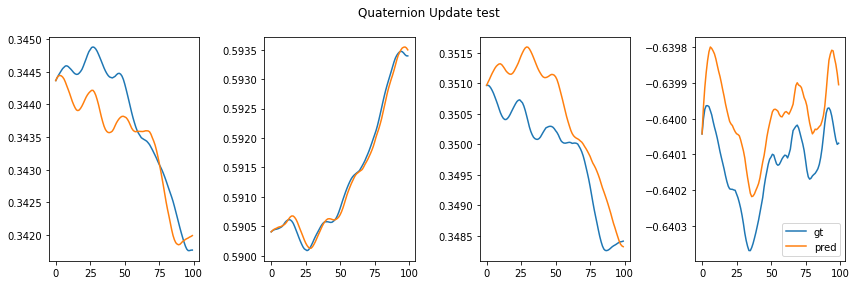

In [4]:
# plot
fig, ax = plt.subplots(1, 4, figsize=(12, 4))
ax[0].plot(q_gt[:,0],)
ax[0].plot(q_pred[:,0],)
ax[1].plot(q_gt[:,1],)
ax[1].plot(q_pred[:,1],)
ax[2].plot(q_gt[:,2],)
ax[2].plot(q_pred[:,2],)
ax[3].plot(q_gt[:,3],label='gt')
ax[3].plot(q_pred[:,3],label='pred')
ax[3].legend()
fig.suptitle('Quaternion Update test')
plt.tight_layout()